#### Import Data and Libraries

In this section I create 3 datasets: 
1. Complete Dataset with all data
2. Data of individuals who have a high Climate Change Risk Perception (q2 >= 6) 
2. Data of individuals who have Low Climate Change Risk Perception (q2 <= 5) 

With all datasets I will predict pro-environmental behaviour (qb5). 

In [1]:
# Import Data 
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve, f1_score
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

df = pd.read_csv('df-climatechange.csv')
df = df.drop(['qb1a','Unnamed: 0','Unnamed: 0.1'], axis = 1)
df['qb5'] = df['qb5'].replace({'No': 0, 'Yes':1})

df1 = df[df.qb2 >= 6]
df2 = df[df.qb2 <= 5]
#pd.set_option('display.max_columns', None)
df.head()

,qb2,qb5,qb4_3,qb4_5,qb7,qb8,qb9,d1,d10,d11,d25,d8,d63,d7,country,cca,cluster
0,4,0,2,2,2,2,2,Centre-left,Man,20,Large town,Still studying,The middle class of society,Single,Belgium,1,1
1,5,0,2,2,2,2,2,Centre-left,Man,55,Large town,Refusal/dk,The middle class of society,Partner and children,Belgium,1,1
2,6,0,2,2,2,1,1,Centre-left,Man,80,Large town,Refusal/dk,The lower middle class of society,Single,Belgium,2,1
3,6,1,2,2,2,2,2,Centre,Man,40,Large town,Refusal/dk,The lower middle class of society,Partner and children,Belgium,1,1
4,5,1,3,3,2,3,2,Centre,Man,55,Large town,Refusal/dk,The middle class of society,Partner and children,Belgium,2,1


In [15]:
len(df)

21978

#### Set parameters Random Search

In [2]:

#parameter for random search 

n_estimators = [int(x) for x in np.linspace(start = 50, stop = 400, num = 6)]
max_depth = [5, 8, 15, 25, 30, None]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 
max_features = ["auto", "sqrt", "log2"]
bootstrap =   [True, False]

param_grid = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, 
                 max_features = max_features,
                 bootstrap = bootstrap)
param_grid

{'n_estimators': [50, 120, 190, 260, 330, 400],
 'max_depth': [5, 8, 15, 25, 30, None],
 'min_samples_split': [2, 5, 10, 15, 100],
 'min_samples_leaf': [1, 2, 5, 10],
 'max_features': ['auto', 'sqrt', 'log2'],
 'bootstrap': [True, False]}

### Complete Dataset

In this part there is the complete dataset. I will predict pro-environmental behaviour (qb5). The predictors are: climate change risk perception, clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 

In [3]:
cc_num = df[['qb5', 'qb2' , 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]
cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']

df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)


#### Split the data into X and y and create training and validating set

In [4]:
seed = 101

X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [5]:
X.shape

(21978, 65)

In [6]:
c = df.groupby('qb5')['qb5'].count()
c #unbalanced

qb5
0     7651
1    14327
Name: qb5, dtype: int64

In [7]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.43641457, 0.76697577])

#### Random search
Random search is a tuning technique that attempts to compute the best values of hyperparameters.

In [8]:
rf = RandomForestClassifier( class_weight={0: 1.43631197 , 1:0.76700502})
# Random search of parameters, using 3 fold cross validation, 
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1, random_state = seed)


rf_classifier.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.43631197,
                                                                  1: 0.76700502}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 120, 190, 260, 330,
                                                         400]},
                   random_state=101)

In [10]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 25, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 1.43631197, 1: 0.76700502},
                       max_depth=25, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=400)


#### Confusion Matrix

Text(0.5, 19.5, 'Predicted label')

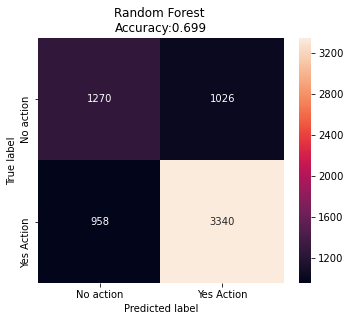

In [11]:
y_pred = rf_classifier.best_estimator_.predict(X_test)

ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))
#print('Accuracy is: ',ac)

plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes Action'], 
                     columns = ['No action','Yes Action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix.png')


#### Feature importance

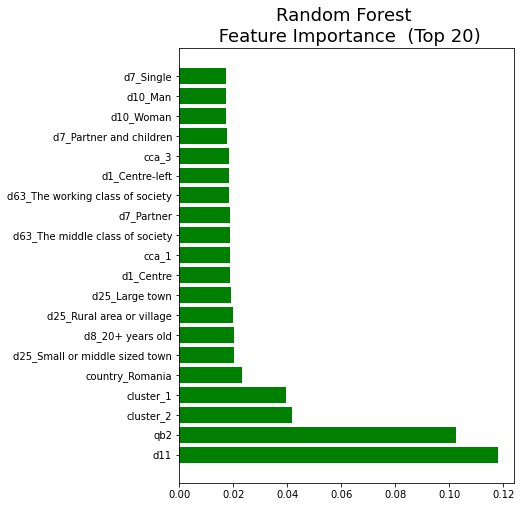

In [14]:
feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 8))

plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
plt.title('Random Forest \n Feature Importance  (Top 20)',
          fontdict= {'fontsize' : 18})
plt.show()

In [26]:
imp = pd.read_csv('imp.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp.csv', index=False, encoding='utf-8')


In [27]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.56      0.55      0.56      2296
           1       0.76      0.77      0.77      4298

    accuracy                           0.70      6594
   macro avg       0.66      0.66      0.66      6594
weighted avg       0.69      0.70      0.69      6594



#### ROC 

An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds.

roc_auc_score for Random Forest - High Risk Perception:  0.7328906119530517


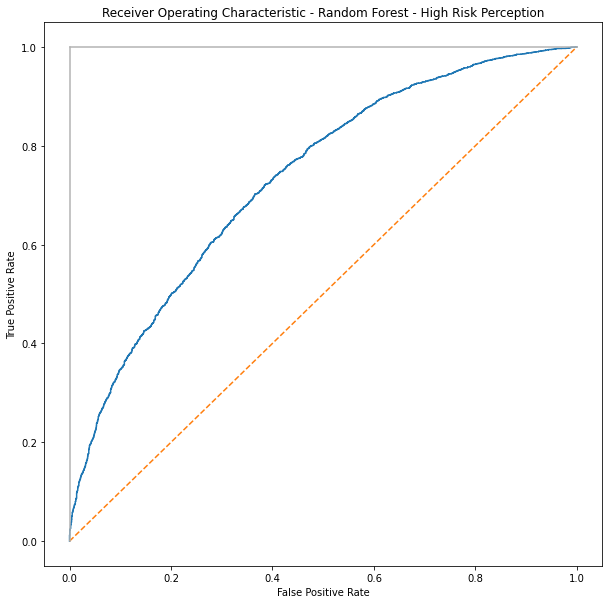

In [164]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic - Random Forest - High Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### High Risk Perception

In this part there is data of individuals who have a high Climate Change Risk Perception (q2 >= 6).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes

In [15]:
cc_num = df1[['qb5', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]
cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)

X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']
seed = 456  # so that the result is reproducible
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)

In [16]:
c = y_test.groupby('qb5')['qb5'].count()
c #unbalanced

qb5
0    1825
1    3897
Name: qb5, dtype: int64

In [17]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))
class_weights

array([1.56726931, 0.73424266])

In [18]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight= {0: 1.56739773 , 1:0.73421448})
# Random search of parameters, using 3 fold cross validation, 
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1,random_state = seed, scoring='f1')


# Fit the random search model
rf_classifier.fit(X_train, y_train.values.ravel())

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 1.56739773,
                                                                  1: 0.73421448}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 120, 190, 260, 330,
                                                         400]},
                   random_state=456, scoring='f1')

In [19]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)


{'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 30, 'bootstrap': True}
RandomForestClassifier(class_weight={0: 1.56739773, 1: 0.73421448},
                       max_depth=30, n_estimators=400)


Text(0.5, 19.5, 'Predicted label')

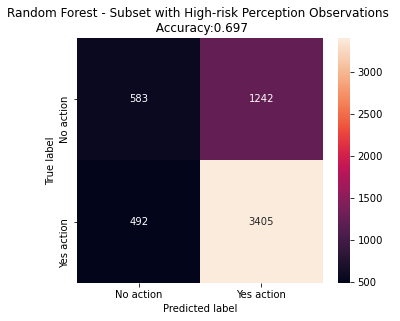

In [20]:
y_pred = rf_classifier.best_estimator_.predict(X_test)

ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))

plt.figure(figsize=(5.5,4.5))
cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['No action','Yes action'], 
                     columns = ['No action','Yes action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest - Subset with High-risk Perception Observations \n Accuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


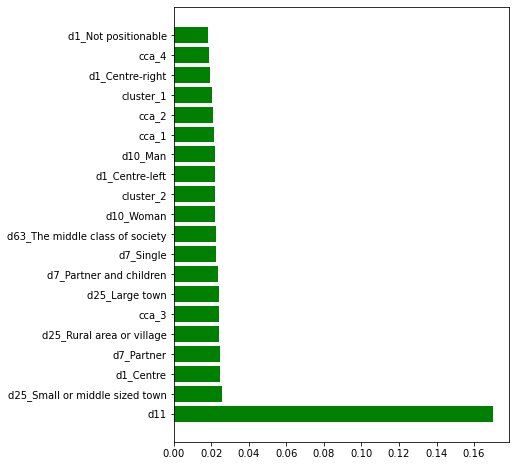

In [21]:

feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)

feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 8))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Random Forest - Feature Importance (Top 20) \n Subset with High-risk Perception Observations',
#          fontdict= {'fontsize' : 18})
plt.show()


In [103]:
imp = pd.read_csv('imp2.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)
dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)
dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)
final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)

final.to_csv('imp2.csv', index=False, encoding='utf-8')

In [104]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.55      0.32      0.41      1825
           1       0.73      0.87      0.80      3897

    accuracy                           0.70      5722
   macro avg       0.64      0.60      0.60      5722
weighted avg       0.67      0.70      0.67      5722



roc_auc_score for Random Forest - High Risk Perception:  0.6926570140009349


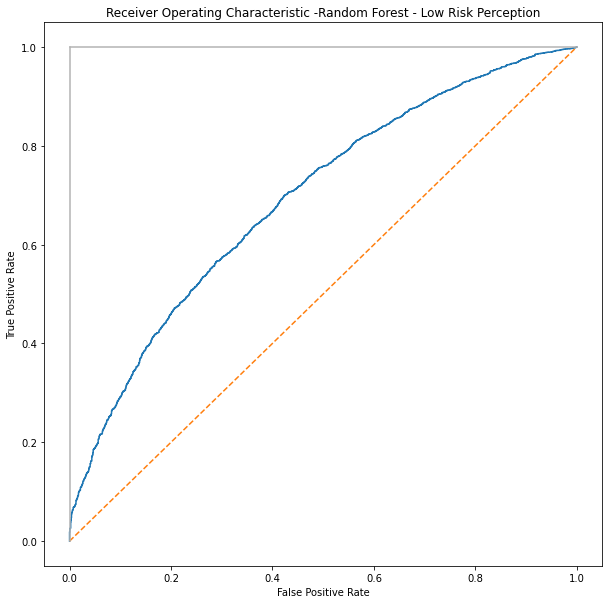

In [84]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - High Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Random Forest - Low Risk Perception')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### Low Risk Perception


In this part there is data of individuals who have a low Climate Change Risk Perception (q2 <= 5).
I will predict pro-environmental behaviour (qb5). The predictors are: clusters and correlational class analysis of other questions about climate change, socio-demograpich variables. 



I repeate the same codes


In [22]:

cc_num = df2[['qb5', 'd1', 'd10','d11', 'country','d8','d25', 'd63','d7','cluster', 'cca']]

cat_var =['d1','d10', 'country','d8','d25', 'd63','d7','cluster', 'cca']
df_get_dummies = pd.get_dummies(  cc_num , columns = cat_var)



X = df_get_dummies.drop('qb5',axis=1)
y = df_get_dummies.loc[:, df_get_dummies.columns == 'qb5']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30, random_state = seed,stratify=y)


In [23]:
c = y_test.groupby('qb5')['qb5'].count()
c #balanced

qb5
0    470
1    402
Name: qb5, dtype: int64

In [24]:
class_weights = compute_class_weight('balanced', classes = np.unique(y_train), y = np.ravel(y_train))


print(class_weights)

[0.92707384 1.08537887]


In [25]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(class_weight= {0:0.9272727 , 1:1.08510638})

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_classifier = RandomizedSearchCV(rf, param_grid, cv = 3, 
                  
                                   n_jobs = -1,random_state = seed, scoring = 'f1')


# Fit the random search model
rf_classifier.fit(X_train, y_train.values.ravel())


RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight={0: 0.9272727,
                                                                  1: 1.08510638}),
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [5, 8, 15, 25, 30, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [50, 120, 190, 260, 330,
                                                         400]},
                   random_state=456, scoring='f1')

In [26]:
print(rf_classifier.best_params_)
print(rf_classifier.best_estimator_)

{'n_estimators': 120, 'min_samples_split': 100, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 25, 'bootstrap': False}
RandomForestClassifier(bootstrap=False,
                       class_weight={0: 0.9272727, 1: 1.08510638}, max_depth=25,
                       max_features='log2', min_samples_leaf=5,
                       min_samples_split=100, n_estimators=120)


Text(0.5, 19.5, 'Predicted label')

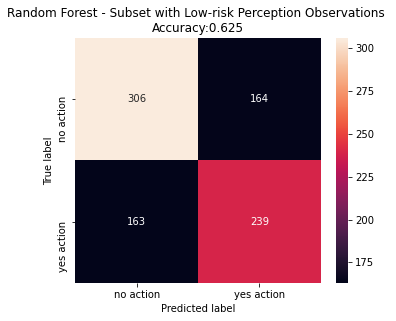

In [27]:
ac = accuracy_score(y_test,rf_classifier.best_estimator_.predict(X_test))

plt.figure(figsize=(5.5,4.5))

cm_df = confusion_matrix(y_test,rf_classifier.best_estimator_.predict(X_test))
cm_df = pd.DataFrame(cm_df,
                     index = ['no action','yes action '], 
                     columns =  ['no action','yes action'])
sns.heatmap(cm_df,annot=True,fmt="d")
plt.title('Random Forest - Subset with Low-risk Perception Observations \nAccuracy:{0:.3f}'.format(accuracy_score(y_test, rf_classifier.best_estimator_.predict(X_test))))
plt.ylabel('True label')
plt.xlabel('Predicted label')
#plt.savefig('rf_confusionmatrix-df24.png')


In [28]:
print(classification_report(y_test, rf_classifier.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.65      0.65      0.65       470
           1       0.59      0.59      0.59       402

    accuracy                           0.62       872
   macro avg       0.62      0.62      0.62       872
weighted avg       0.63      0.62      0.63       872



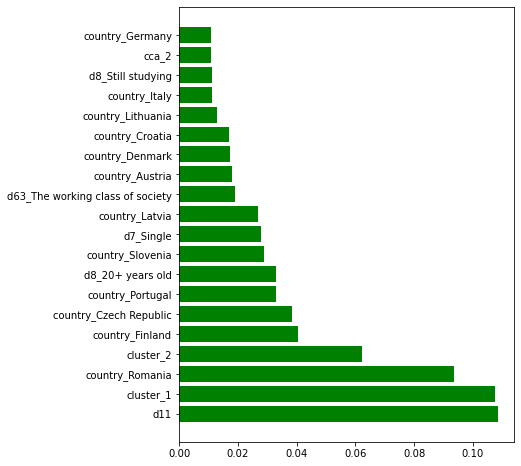

In [112]:
feature_importances = list(zip(X_train, rf_classifier.best_estimator_.feature_importances_))
# Then sort the feature importances by most important first
feature_importances_ranked = sorted(feature_importances, key = lambda x: x[1], reverse = True)
feature_names_20 = [i[0] for i in feature_importances_ranked[:20]]
y_ticks = np.arange(0, len(feature_names_20))
x_axis = [i[1] for i in feature_importances_ranked[:20]]
plt.figure(figsize = (6, 8))
plt.barh(feature_names_20, x_axis, color = 'g')   #horizontal barplot
#plt.title('Random Forest - Feature Importance (Top 20) \n Subset with Low-risk Perception Observations',
#          fontdict= {'fontsize' : 18})
#plt.xlabel('Features',fontdict= {'fontsize' : 16})
plt.show()

In [113]:
imp = pd.read_csv('imp3.csv')
imp  = imp.sort_values('variable', ascending=True).reset_index(drop=True)

dt = pd.DataFrame(feature_importances)
dt.rename(columns={ dt.columns[0]: "variable" }, inplace = True)

dt  = dt.sort_values('variable', ascending=True).reset_index(drop=True)

final = pd.merge(imp, dt, left_index=True, right_index=True)

final.rename(columns={ final.columns[4]: "importance_rf" }, inplace = True)
final.rename(columns={ final.columns[0]: "variable" }, inplace = True)
final = final.drop('variable_y', axis = 1)


final.to_csv('imp3.csv', index=False, encoding='utf-8')

In [43]:
imp = pd.read_csv('imp3.csv')
imp

,variable,importance_lg,importance_dt,importance_rf,importance_gb
0,cca_1,0.017753,0.000000,0.017036,0.012917
1,cca_2,0.167401,0.000000,0.017164,0.014193
2,cca_3,0.398833,0.000000,0.019588,0.005926
3,cca_4,-0.405617,0.000000,0.015154,0.015988
4,cca_5,-0.561250,0.000000,0.013371,0.018173
5,cluster_1,-0.256186,0.426276,0.045347,0.038921
6,cluster_2,0.735099,0.000000,0.042780,0.000000
7,country_Austria,-0.398833,0.000000,0.014558,0.017754
8,country_Belgium,0.080522,0.000000,0.004800,0.009789
9,country_Bulgaria,0.052831,0.000000,0.001363,0.024866


roc_auc_score for Random Forest - Low Risk Perception:  0.6792023922938499


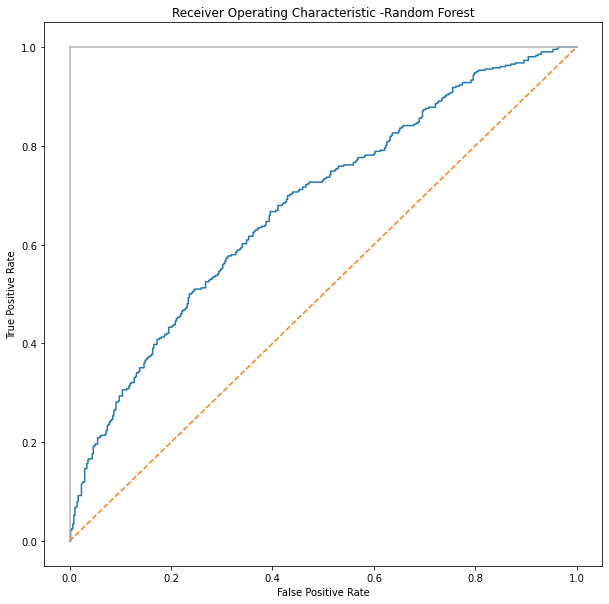

In [114]:
y_score2 = rf_classifier.best_estimator_.predict_proba(X_test)[:,1]
false_positive_rate2, true_positive_rate2, threshold2 = roc_curve(y_test, y_score2)
print('roc_auc_score for Random Forest - Low Risk Perception: ', roc_auc_score(y_test, y_score2))
plt.subplots(1, figsize=(10,10))
plt.title('Receiver Operating Characteristic -Random Forest')
plt.plot(false_positive_rate2, true_positive_rate2)
plt.plot([0, 1], ls="--")
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

#### REFERENCES 

https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

https://towardsdatascience.com/my-random-forest-classifier-cheat-sheet-in-python-fedb84f8cf4f

